<a href="https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/master/Notebooks/How_to_compare_tumor_features_with_gene_expression_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ISB-CGC Community Notebooks

Check out more notebooks at our [Community Notebooks Repository](https://github.com/isb-cgc/Community-Notebooks)!

```
Title:   Calculating associations between radiomics tumor features and gene expression
Author:  Fabian Seidl, Boris Aguilar
Created: 2021-06-15
URL:     https://github.com/isb-cgc/Community-Notebooks/blob/master/Notebooks/How_to_compare_tumor_features_with_gene_expression_data.ipynb
Purpose: To demonstrate multi-omics data analysis using table joins in Google BigQuery
Notes: 
```

# Overview

This notebook showcases an analysis workflow combining tumor features with gene expression data mostly run in Google BigQuery. In this notebook we will:

> 1. Subset the gene expression in ISB-CGC BigQuery tables for Glioblastoma Multiforme.
> 2. Join these expression data to tumor features extracted from radiomics data.
> 3. Calculate Spearman correlations between tumor features and gene expression.

The tumor feature data we used in this notebook are from Bakas et al. Nature Scientific 2017 (https://www.nature.com/articles/sdata2017117) and the gene expression values come from the GDC data housed in ISB-CGC BigQuery tables.

First we initialize our python environment and authenticate our session.

In [ ]:
from google.colab import auth
import pandas_gbq
import pandas as pd
import numpy
import seaborn
from google.cloud import bigquery

bq_project='<your_google_project_here>'
auth.authenticate_user()
client = bigquery.Client(project=bq_project)
print('Authenticated')

Authenticated


# Joining the data
The radiomics data we are using are stored in the `isb-cgc-idc-collaboration.Analysis.unpivoted_tcga_gbm_radiomicFeatures` BigQuery table. We will join these data with expression data stored in `isb-cgc-bq.TCGA.RNAseq_hg38_gdc_current` with an SQL query.

In [ ]:
gdc_project = 'GBM'
rna_seq_table = "isb-cgc-bq.TCGA.RNAseq_hg38_gdc_current"
radiomics_table = "isb-cgc-idc-collaboration.Analysis.unpivoted_tcga_{0}_radiomicFeatures".format(gdc_project.lower())

join_query1 = """
WITH 
rnaseq AS (
   select case_barcode, gene_name, aliquot_barcode, Ensembl_gene_id, MAX(HTSeq__Counts) gexp 
   from
	   {0} as rna
   WHERE 
      gene_type = 'protein_coding'
      AND project_short_name = 'TCGA-{1}'
   GROUP BY Ensembl_gene_id, gene_name, case_barcode, aliquot_barcode
),
""".format(rna_seq_table, gdc_project)

join_query2 = """
combined AS (
   SELECT Ensembl_gene_id, gene_name, feature, gexp, value ,
      (RANK() OVER( PARTITION BY Ensembl_gene_id,feature ORDER BY gexp )) + (COUNT(*) OVER (PARTITION BY Ensembl_gene_id,feature, CAST(gexp AS STRING)) - 1)/2.0  AS rankx,
      (RANK() OVER( PARTITION BY Ensembl_gene_id,feature ORDER BY value )) AS ranky
   FROM rnaseq
   JOIN {0} img
   ON img.ID = case_barcode
      AND img.feature LIKE "VOLUME%" 
      AND img.value IS NOT NULL
)
""".format(radiomics_table)

# The query results of this are very large, so we only pull the first 5 rows
select_query = """
SELECT * FROM combined LIMIT 5
"""

query_job = client.query( join_query1 + join_query2 + select_query )
joined_data = query_job.result().to_dataframe()
joined_data.head(5)

,Ensembl_gene_id,gene_name,feature,gexp,value,rankx,ranky
0,ENSG00000001460,STPG1,VOLUME_ET_OVER_NET,65,0.186594547,4.0,1
1,ENSG00000001460,STPG1,VOLUME_ET_OVER_NET,16,0.385678479,1.0,2
2,ENSG00000001460,STPG1,VOLUME_ET_OVER_NET,80,0.787813852,5.0,3
3,ENSG00000001460,STPG1,VOLUME_ET_OVER_NET,151,1.133679513,9.0,4
4,ENSG00000001460,STPG1,VOLUME_ET_OVER_NET,299,1.602529282,13.0,5


# Calculating correlation values
We can use the table from the previous query and pipe the results directly to the next analysis by adding on syntax to calculate the correlations between the volumes and the expression vectors for each gene and feature type.

The query groups by gene_name and by tumor feature and then calls the built in CORR() function of SQL.

In [ ]:
correlation_query = """,
correlation AS (
   SELECT Ensembl_gene_id, gene_name, feature,  COUNT(gexp) as n, CORR(rankx,ranky)  as corr 
   FROM combined
   GROUP BY Ensembl_gene_id, gene_name, feature
)
"""

# a select query to pull just a subset
select_corr_query = """SELECT * FROM correlation LIMIT 5"""

rank_job = client.query( join_query1 + join_query2 + correlation_query + select_corr_query )
rank_data = rank_job.result().to_dataframe()
rank_data.head(5)

,Ensembl_gene_id,gene_name,feature,n,corr
0,ENSG00000003249,DBNDD1,VOLUME_WT_OVER_BRAIN,22,0.071553
1,ENSG00000004478,FKBP4,VOLUME_NET_OVER_WT,22,-0.169386
2,ENSG00000005421,PON1,VOLUME_NET_OVER_ED,22,0.220239
3,ENSG00000010803,SCMH1,VOLUME_ED_over_BRAIN,22,0.222237
4,ENSG00000012779,ALOX5,VOLUME_ET,22,-0.145212


# Performing t-tests with a User Defined Function
These correlations can then be used to call a user defined function to calcuate significance values by t-test statistics.

In [ ]:
pvalue_query = """
SELECT  feature, Ensembl_gene_id, gene_name, n, corr,
   `cgc-05-0042.functions.jstat_ttest`(t, n-2, 2) as p
FROM (
   SELECT *, 
         ABS(corr)*SQRT( (n-2)/((1-corr*corr))) AS t
   FROM correlation
   WHERE  ABS(corr) < 1.0
     )
ORDER BY p
"""

statistics_job = client.query( join_query1 + join_query2 + correlation_query + pvalue_query )
statistics_table = statistics_job.result().to_dataframe()
statistics_table.head(5)

,feature,Ensembl_gene_id,gene_name,n,corr,p
0,VOLUME_TC,ENSG00000131037,EPS8L1,22,-0.844592,0.000001
1,VOLUME_TC_over_BRAIN,ENSG00000131037,EPS8L1,22,-0.837822,0.000002
2,VOLUME_BRAIN,ENSG00000106689,LHX2,22,-0.815268,0.000005
3,VOLUME_BRAIN,ENSG00000119559,C19orf25,22,-0.807612,0.000007
4,VOLUME_NET,ENSG00000171433,GLOD5,22,-0.806596,0.000007


We can use these data for further analysis or simply generate a summary plot as below:

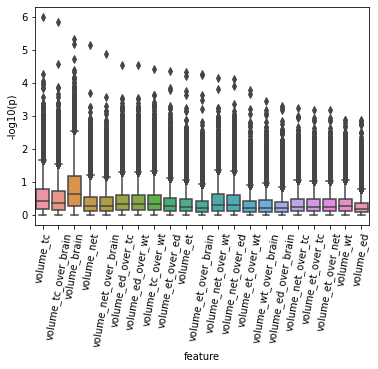

In [ ]:
statistics_table['neglog10'] = -numpy.log10(statistics_table['p'])

bxplt = seaborn.boxplot(x=statistics_table['feature'], 
                        y=statistics_table['neglog10'], 
                        data=statistics_table
                        )
labels = [x.get_text().lower() for x in bxplt.get_xticklabels()]
jnk = bxplt.set_xticklabels(labels, rotation=80, size=10)
jnk = bxplt.set(ylabel='-log10(p)')

In [ ]:
# The full query
print(join_query1 + join_query2 + correlation_query + pvalue_query)


WITH 
rnaseq AS (
   select case_barcode, gene_name, aliquot_barcode, Ensembl_gene_id, MAX(HTSeq__Counts) gexp 
   from
	   isb-cgc-bq.TCGA.RNAseq_hg38_gdc_current as rna
   WHERE 
      gene_type = 'protein_coding'
      AND project_short_name = 'TCGA-GBM'
   GROUP BY Ensembl_gene_id, gene_name, case_barcode, aliquot_barcode
),

combined AS (
   SELECT Ensembl_gene_id, gene_name, feature, gexp, value ,
      (RANK() OVER( PARTITION BY Ensembl_gene_id,feature ORDER BY gexp )) + (COUNT(*) OVER (PARTITION BY Ensembl_gene_id,feature, CAST(gexp AS STRING)) - 1)/2.0  AS rankx,
      (RANK() OVER( PARTITION BY Ensembl_gene_id,feature ORDER BY value )) AS ranky
   FROM rnaseq
   JOIN isb-cgc-idc-collaboration.Analysis.unpivoted_tcga_gbm_radiomicFeatures img
   ON img.ID = case_barcode
      AND img.feature LIKE "VOLUME%" 
      AND img.value IS NOT NULL
)
,
correlation AS (
   SELECT Ensembl_gene_id, gene_name, feature,  COUNT(gexp) as n, CORR(rankx,ranky)  as corr 
   FROM combined
   GROUP